توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
%%capture
## download data

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
# function 1
def displacement(img):

    rows, cols, _ = img.shape
    max_displacement = 60  # Adjust as needed
    dx = np.random.randint(-max_displacement, max_displacement)
    dy = np.random.randint(-max_displacement, max_displacement)

    # Create remap matrices
    map_x = np.tile(np.arange(cols), (rows, 1)) + dx
    map_y = np.tile(np.arange(rows), (cols, 1)).T + dy

    # Clip values to stay within image boundaries
    map_x = np.clip(map_x, 0, cols - 1)
    map_y = np.clip(map_y, 0, rows - 1)

    # Apply remapping to shift the image
    img = cv2.remap(img, map_x.astype(np.float32), map_y.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    return img


# function 2
def rotation(img):
    ## To Do

    # Rotate
    angle = np.random.uniform(-50, 50)  # Adjust as needed
    rows, cols, _ = img.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, rotation_matrix, (cols, rows), borderMode=cv2.BORDER_REPLICATE)

    return img


# function 3
def scaling(img):
    ## To Do

    zoom_factor = np.random.uniform(0.5, 0.9)

    # Get the dimensions of the input image
    height, width, _ = img.shape

    # Calculate the new dimensions after zooming
    new_height = int(height / zoom_factor)
    new_width = int(width / zoom_factor)

    # Resize the image using the calculated dimensions
    img_zoomed = cv2.resize(img, (new_width, new_height))

    # Crop the zoomed image by its original size
    crop_top_left_x = (new_width - width) // 2
    crop_top_left_y = (new_height - height) // 2
    img = img_zoomed[crop_top_left_y:crop_top_left_y + height, crop_top_left_x:crop_top_left_x + width]

    return img


# function 4
def Brightness(img):  ## for augmentation
    ## To Do
    factor = randint(1,5)
#     factor = 5

    # Loop over each pixel and increase the intensity
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                img[i, j, k] = min(255, int(img[i, j, k] * factor))

    return img

# function 5
def bluring(img):# for augmentation
    ## To Do
    kernel_size = 3
    height, width, channels = img.shape
    blurred_img = img.copy()

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            for c in range(channels):
                img[i, j, c] = sum(
                    img[i - 1 : i + 2, j - 1 : j + 2, c].flatten()
                ) // (kernel_size ** 2)
    return img

# function 6
def gaussian_noise(img):#for augmentation
  ## To Do
  # Example: Adding Gaussian noise
  mean = 0
  std_dev = 10  # Adjust as needed
  img = img + np.random.normal(mean, std_dev, img.shape).astype(np.uint8)

  return img

In [4]:
class CustomDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

        ##
#         fraction_to_keep = 1
#         total_samples = len(self.file_paths)
#         num_samples_to_keep = int(fraction_to_keep * total_samples)
#         self.indices = random.sample(range(total_samples), num_samples_to_keep)
        ##

    def __getitem__(self, idx):

#         idx = self.indices[idx]
        ##

        original_image = cv2.imread(self.file_paths[idx])
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Choose a random number of transformations (either 1, 2)
        num_transforms = np.random.choice([1, 2])

        # Randomly choose transformation functions without replacement
        chosen_transforms = np.random.choice([displacement, rotation, scaling], size=num_transforms, replace=False)
        # chosen_transforms = [rotation]

        # Apply the chosen transformations
        transformed_image = original_image
        for transformfunc in chosen_transforms :
            transformed_image = transformfunc(transformed_image)
            if transformfunc == scaling and np.random.choice([0, 1]) == 1:
                original_image = transformed_image
                transformed_image = original_image


        # Create a label vector indicating which transformations are applied
        # Assuming the order: [displacement, rotation, scaling]
        label = np.zeros(3)
        for transform_func in chosen_transforms:
            if transform_func == displacement:
                label[0] = 1
            elif transform_func == rotation:
                label[1] = 1
            elif transform_func == scaling:
                label[2] = 1

        # Apply additional transformations
        if self.transform is not None:
            original_image = self.transform(original_image)
            transformed_image = self.transform(transformed_image)

        return {
            'original_image': original_image,
            'transformed_image': transformed_image,
            'label': label.astype(np.float32)
        }

    def __len__(self):
        return len(self.file_paths)
#         return len(self.indices)

In [5]:
def collate_fn(batch):
    # Resize images to a common size
    resized_original = [torch.nn.functional.interpolate(item['original_image'].unsqueeze(0), size=(224, 224), mode='nearest').squeeze(0) for item in batch]
    resized_transformed = [torch.nn.functional.interpolate(item['transformed_image'].unsqueeze(0), size=(224, 224), mode='nearest').squeeze(0) for item in batch]
    labels = torch.stack([torch.from_numpy(item['label']) for item in batch])
    return {
        'original_image': torch.stack(resized_original),
        'transformed_image': torch.stack(resized_transformed),
        'label': labels
    }

# Define file paths for the datasets
train_images_path = "ADEChallengeData2016/images/training"
# train_annotations_path = "ADEChallengeData2016/annotations/training"
test_images_path = "release_test/testing"
val_images_path = "ADEChallengeData2016/images/validation"
# Assuming you have defined your train_loader and test_loader
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_images_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_dataset = CustomDataset(val_images_path, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=4)
test_dataset = CustomDataset(test_images_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=4)


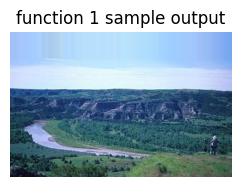

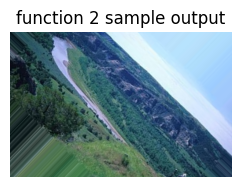

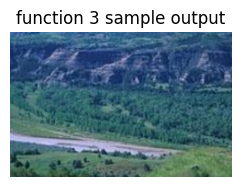

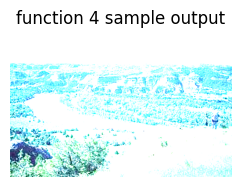

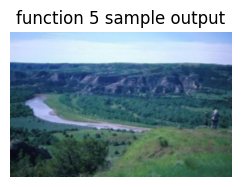

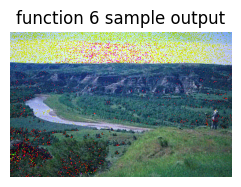

In [6]:
img = cv2.imread(f'/kaggle/working/ADEChallengeData2016/images/training/ADE_train_00000004.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# List of transformations
transformations = [displacement, rotation, scaling, Brightness, bluring, gaussian_noise]
# transformations = [bluring]

# Initialize an empty list to store transformed images
images = [None] * len(transformations)

# Apply transformations and display results
for i, transform in enumerate(transformations):
    im = img.copy()
    images[i] = transform(im)

    plt.figure(figsize=(20, 20))

    plt.subplot(1, 6, i + 1)
    plt.imshow(images[i])
    plt.title(f"function {i+1} sample output")
    plt.axis("off")

plt.show()

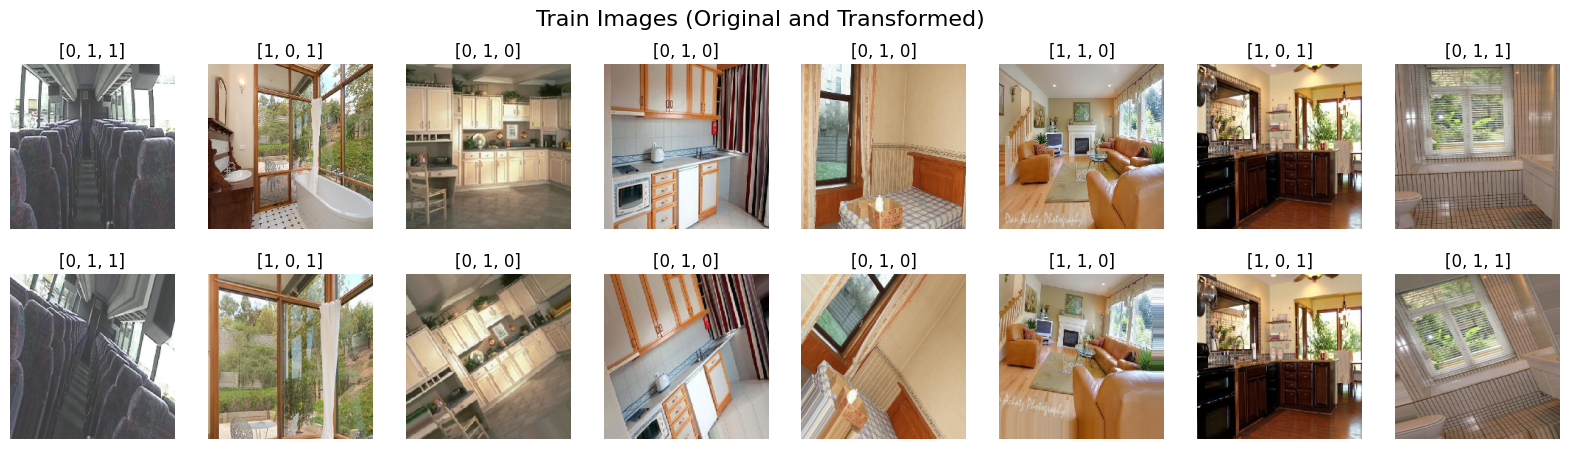

In [7]:
# Get a batch from train_loader
batch = next(iter(train_loader))
# Show images
def display_images(images, transformed_images, labels, title):
    num_images = len(images)

    # Display original images
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=16)

    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.axis("off")
        plt.title(f"{[int(value) for value in labels[i]]}")

    # Display transformed images
    for i in range(num_images):
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(np.transpose(transformed_images[i].numpy(), (1, 2, 0)))
        plt.axis("off")
        plt.title(f"{[int(value) for value in labels[i]]}")

    plt.show()

# Assuming 'batch_labels' is a list of labels for each image in the batch
batch_labels = batch['label'][:8]

original_images = batch['original_image'][:8]
transformed_images = batch['transformed_image'][:8]
display_images(original_images, transformed_images, batch_labels, "Train Images (Original and Transformed)")


##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

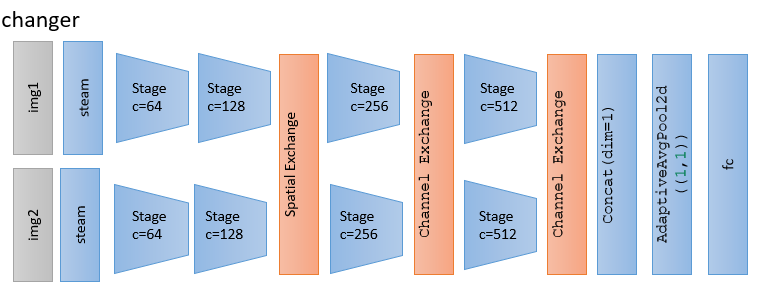

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


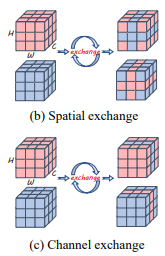

In [8]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

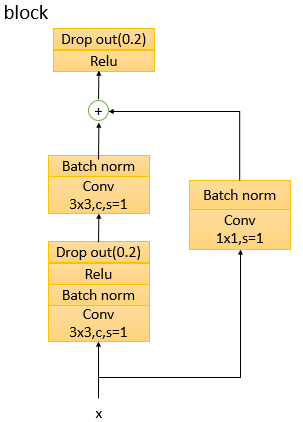

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





padding(conv) = 1 \\
channel out size (conv(1*1)) = c

The use of a 1x1 convolution is generally for reducing the number of channels and controlling model complexity. This layer, with a 1x1 kernel, can alter the channel dimensions and allow the model to learn more complex patterns in the later stages of the network. It also helps in reducing computations and speeding up the network.

In [9]:
##To Do
class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(block, self).__init__()

        # First branch: Conv -> BatchNorm -> ReLU -> Dropout -> Conv -> BatchNorm
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        # Second branch: Conv -> BatchNorm
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels)
        )

        # Final ReLU and Dropout
        self.relu_dropout = nn.Sequential(
            nn.ReLU(),
            nn.Dropout2d(0.2)
        )

    def forward(self, x):
        # Forward pass through both branches
        out1 = self.branch1(x)
        out2 = self.branch2(x)

        # Add the outputs of both branches
        out = out1 + out2

        # Apply final ReLU and Dropout
        out = self.relu_dropout(out)

        return out

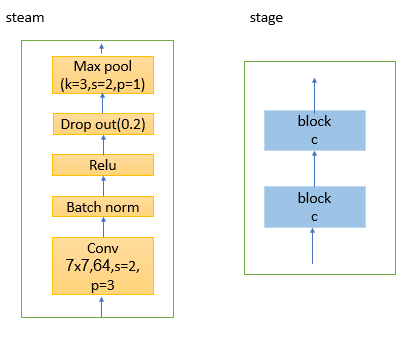

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [10]:
#To Do
class changer(nn.Module):
    def __init__(self, block, SpatialExchange, ChannelExchange):
        super(changer, self).__init__()
        num_classes = 3

        self.steam = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.stage1 = self._make_stage(block, 64, 64)
        self.stage2 = self._make_stage(block, 64, 128)
        self.spatial_exchange = SpatialExchange()
        self.stage3 = self._make_stage(block, 128, 256)
        self.channel_exchange = ChannelExchange()
        self.stage4 = self._make_stage(block, 256, 512)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(1024, num_classes)
        self.sig = nn.Sigmoid()

    def _make_stage(self, block, in_channels, out_channels):
        layers = [block(in_channels, out_channels), block(out_channels, out_channels)]
        return nn.Sequential(*layers)

    def forward(self, x1, x2):
        out1 = self.steam(x1)
        out1 = self.stage1(out1)
        out1 = self.stage2(out1)

        out2 = self.steam(x2)
        out2 = self.stage1(out2)
        out2 = self.stage2(out2)

        out1, out2 = self.spatial_exchange(out1, out2)
        out1 = self.stage3(out1)
        out2 = self.stage3(out2)
        out1, out2 = self.channel_exchange(out1, out2)
        out1 = self.stage4(out1)
        out2 = self.stage4(out2)
        out1, out2 = self.channel_exchange(out1, out2)

        out = torch.cat([out1, out2], dim=1)

        out = self.adaptive_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.sig(out)

        return out

In [11]:
## To Do

num_classes = 3
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=changer(block,SpatialExchange,ChannelExchange).to(device)

# The loss function
criterion = nn.BCELoss()

# Define the optimizer (e.g., Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) ## optimizer

num_epochs = 10

##Train & validation


In [12]:
Loss_train = []
Loss_val = []
Acc_train = []
Acc_val = []

num_epochs = 5

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct = [0] * num_classes
    num_data = [0] * num_classes
    step = 0
    for data in train_loader:
        inputs1, inputs2, labels = data['original_image'].to(device), data['transformed_image'].to(device), data['label'].to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs1, inputs2)
        # Compute the loss
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()


        predictions = (outputs >= 0.5).int()
        for i in range(num_classes):
          correct[i] += int(sum(predictions[:, i] == labels[:, i]))
          num_data[i] += len(inputs1)

    train_loss /= len(train_loader)

    acc_train = [0] * num_classes
    for i in range(num_classes):
      acc_train[i] = 100. * (correct[i] / num_data[i])

    # Validation
    model.eval()
    val_loss = 0.0
    correct = [0] * num_classes
    num_data = [0] * num_classes

    with torch.no_grad():
        for data in val_loader:
            inputs1, inputs2, labels = data['original_image'].to(device), data['transformed_image'].to(device), data['label'].to(device)

            # Forward pass
            outputs = model(inputs1, inputs2)

            # Compute the loss
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predictions = (outputs > 0.5).int()
            for i in range(num_classes):
              correct[i] += int(sum(predictions[:, i] == labels[:, i]))
              num_data[i] += len(inputs1)

    val_loss /= len(val_loader)
    acc_val = [0] * num_classes
    for i in range(num_classes):
      acc_val[i] = 100. * (correct[i] / num_data[i])

    Loss_train.append(train_loss)
    Loss_val.append(val_loss)
    
    Acc_train.append(sum(acc_train) / num_classes)
    Acc_val.append(sum(acc_val) / num_classes)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss (Train): {train_loss:.4f}, Loss (Val): {val_loss:.4f}')
    for i in range(num_classes):
      print(f'accuracy class {i}: Train: {acc_train[i]}, Val: {acc_val[i]}')
    
    # save the checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': optimizer.loss() #??????
    }
    torch.save(checkpoint, f'checkpoint{epoch}.pth')


Epoch [1/5], Loss (Train): 0.6938, Loss (Val): 0.6732
accuracy class 0: Train: 50.44037605145968, Val: 59.099999999999994
accuracy class 1: Train: 53.96338446313707, Val: 61.35
accuracy class 2: Train: 54.27016328550223, Val: 54.800000000000004
Epoch [2/5], Loss (Train): 0.6661, Loss (Val): 0.6415
accuracy class 0: Train: 56.1306284017813, Val: 59.35
accuracy class 1: Train: 61.741712023750615, Val: 63.1
accuracy class 2: Train: 60.75210291934686, Val: 63.5
Epoch [3/5], Loss (Train): 0.6493, Loss (Val): 0.6512
accuracy class 0: Train: 58.0801583374567, Val: 59.8
accuracy class 1: Train: 62.177140029688275, Val: 64.75
accuracy class 2: Train: 63.814943097476494, Val: 60.6
Epoch [4/5], Loss (Train): 0.6417, Loss (Val): 0.6285
accuracy class 0: Train: 58.78278080158338, Val: 59.45
accuracy class 1: Train: 62.8698664027709, Val: 64.75
accuracy class 2: Train: 64.98762988619495, Val: 67.35
Epoch [5/5], Loss (Train): 0.6320, Loss (Val): 0.6301
accuracy class 0: Train: 59.80702622464127, Val:

#Test


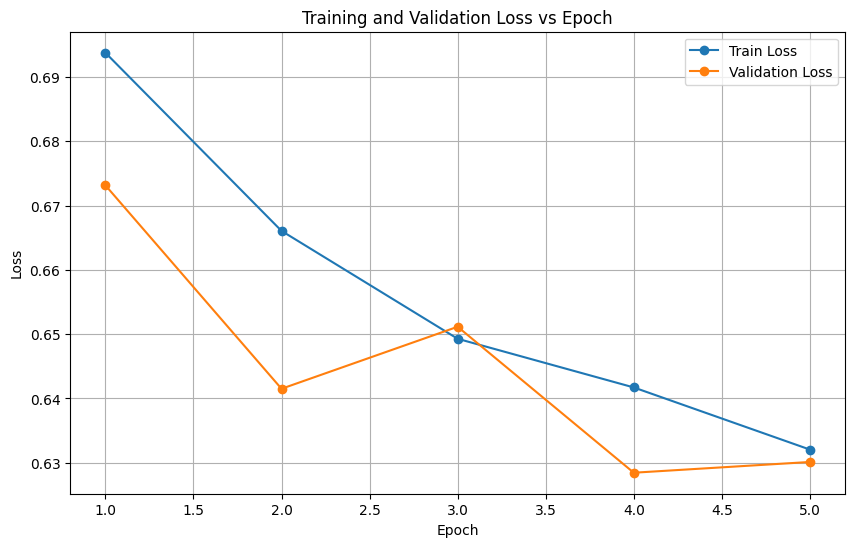

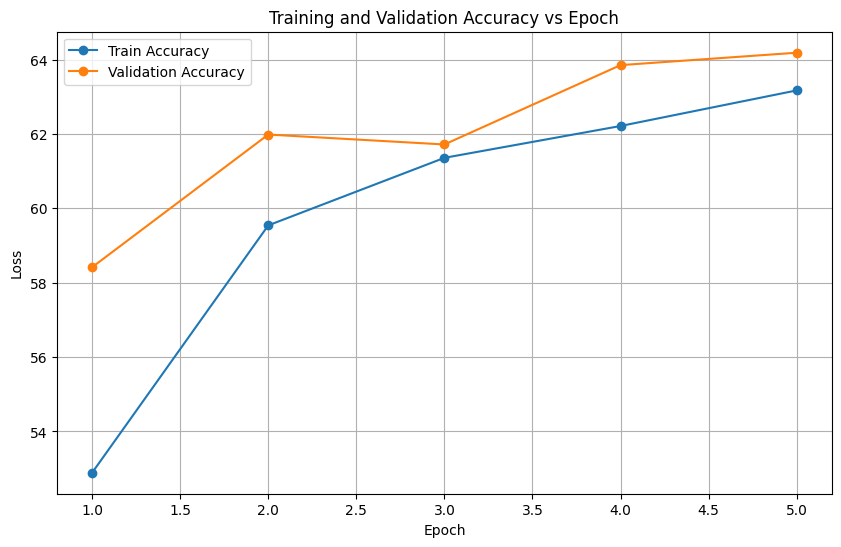

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), Loss_train, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), Loss_val, label='Validation Loss', marker='o')

plt.title('Training and Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), Acc_train, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), Acc_val, label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Load the model checkpoint
checkpoint = torch.load('checkpoint4.pth')  
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [18]:
## To Do test

# print(f' loss_test= {:.3f}, acc_test={()}')

# Set the model to evaluation mode
model.eval()

# To Do: Define your test loader (assuming 'test_loader' is already defined)

# Initialize variables for testing
test_loss = 0.0
correct = [0] * num_classes
num_data = [0] * num_classes

with torch.no_grad():
    for data in test_loader:
        inputs1, inputs2, labels = data['original_image'].to(device), data['transformed_image'].to(device), data['label'].to(device)

        # Forward pass
        outputs = model(inputs1, inputs2)

        # Compute the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Compute accuracy
        predictions = (outputs > 0.5).int()
        for i in range(num_classes):
            correct[i] += int(sum(predictions[:, i] == labels[:, i]))
            num_data[i] += len(inputs1)

# Calculate average test loss
test_loss /= len(test_loader)

# Calculate accuracy
acc_test = [0] * num_classes
for i in range(num_classes):
    acc_test[i] = 100. * (correct[i] / num_data[i])

# Print the test loss and accuracy
print(f'Test Loss: {test_loss:.3f}')
for i in range(num_classes):
    print(f'Accuracy class {i}: {acc_test[i]:.2f}%')



Test Loss: 0.624
Accuracy class 0: 60.71%
Accuracy class 1: 65.24%
Accuracy class 2: 65.84%


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

Images with only one transition can be recognized better by the model. Since applying more transitions add ambiguity on the prediction of the classes.